In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 200

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_N_sheet
from joblib import Parallel, delayed
from tqdm import tqdm

vispy  won't work


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
geom.update_all(sheet)

In [4]:
specs = {'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5700,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 13},
 'vert': {'barrier_elasticity': 280, 'delta_rho': 0},
        }

In [7]:
els_lumen, els_barrier = np.meshgrid(np.linspace(1e-4, 1e-2, 10), np.linspace(0.0, 0.4, 10))

"""this function allows to apply barrier elasticity, lumen volume elasticity 
and to calculate diameter, anisocell, area and perimeter of the cell"""

def multi_parameters(l, b):
    solver = QSSolver(with_t1=False, with_t3=False)
    sheet_copy = sheet.copy()
    sheet_copy.settings['lumen_vol_elasticity']= l
    sheet_copy.vert_df['barrier_elasticity'] = b
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-8})
    diameter = 2*(sheet_copy.vert_df["z"].max())
    center_verts =  sheet_copy.vert_df.loc[np.abs(sheet.vert_df["z"]) < 1]
    sheet_copy.face_df['anisotropy'] = aniso(sheet_copy, coords = ['x','y','z'])
    center = np.abs(sheet_copy.face_df["z"]) < sheet_copy.face_df["z"].max()*0.75
    aniso_cell = sheet_copy.face_df.loc[center, 'anisotropy'].mean()
    area = sheet_copy.face_df.loc[center, 'area'].mean()#area of the cell
    c_perimeter = sheet_copy.face_df['perimeter'].mean()
    
    
    return res, diameter, aniso_cell, area, c_perimeter, l, b


In [8]:
results = Parallel(n_jobs=2)(delayed(multi_parameters)(l, b) for l, b in tqdm(zip(els_lumen.ravel(), els_barrier.ravel())))



0it [00:00, ?it/s]
4it [00:12,  3.25s/it]
6it [00:57, 11.10s/it]
8it [01:03,  8.12s/it]
10it [01:18,  7.87s/it]
12it [01:30,  7.33s/it]
14it [01:51,  8.37s/it]
16it [02:35, 12.61s/it]
18it [02:41,  9.70s/it]
20it [02:56,  8.99s/it]
22it [03:01,  7.00s/it]
24it [03:30,  9.21s/it]
26it [04:13, 12.96s/it]
28it [04:19, 10.01s/it]
30it [04:31,  8.79s/it]
32it [04:34,  6.51s/it]
34it [05:04,  9.18s/it]
36it [05:48, 12.97s/it]
38it [05:54,  9.99s/it]
40it [06:03,  8.36s/it]
42it [06:09,  6.70s/it]
44it [06:36,  8.82s/it]
46it [07:20, 12.68s/it]
48it [07:26,  9.80s/it]
50it [07:39,  8.84s/it]
52it [07:41,  6.51s/it]
54it [08:12,  9.16s/it]
56it [08:54, 12.79s/it]
58it [09:01,  9.86s/it]
60it [09:11,  8.41s/it]
62it [09:15,  6.50s/it]
64it [09:43,  8.86s/it]
66it [10:26, 12.64s/it]
68it [10:33,  9.80s/it]
70it [10:44,  8.58s/it]
72it [10:47,  6.50s/it]
74it [11:17,  9.03s/it]
76it [12:00, 12.71s/it]
78it [12:06,  9.86s/it]
80it [12:17,  8.50s/it]
82it [12:21,  6.57s/it]
84it [12:51,  9.13s/it]

In [13]:
# Convert results to DataFrame
df_results = pd.DataFrame.from_records(results, columns=['res', 'diameter', 'aniso_cell', 'area', 'c_perimeter', 'l', 'b'])
# Save the DataFrame to a CSV file
df_results.to_csv('df_results.csv', index=True)

In [14]:
df_results

,res,diameter,aniso_cell,area,c_perimeter,l,b
0,"{'fun': 33.978371185963226, 'jac': [-0.0084202...",33.794607,0.254733,0.941158,3.820084,0.0001,0.0
1,"{'fun': 157.44570830790536, 'jac': [-0.0269983...",33.827430,0.256347,0.983515,3.900166,0.0012,0.0
2,"{'fun': 194.01019439823824, 'jac': [-0.0162741...",33.881290,0.257192,0.995698,3.922662,0.0023,0.0
3,"{'fun': 210.8086000500648, 'jac': [-0.06149753...",33.921340,0.257460,1.001200,3.934085,0.0034,0.0
4,"{'fun': 234.82204642030857, 'jac': [-0.0520455...",34.050778,0.258935,1.011310,3.954959,0.0045,0.0
...,...,...,...,...,...,...,...
95,"{'fun': 236.93588045732955, 'jac': [-0.0487509...",34.051625,0.258838,1.011394,3.955285,0.0056,0.4
96,"{'fun': 238.80724770561184, 'jac': [-0.0438835...",34.051755,0.258840,1.011401,3.955304,0.0067,0.4
97,"{'fun': 237.17184182873342, 'jac': [-0.0128396...",34.010990,0.258285,1.009503,3.950378,0.0078,0.4
98,"{'fun': 242.5305283157258, 'jac': [-0.03425050...",34.051977,0.258843,1.011416,3.955341,0.0089,0.4


In [11]:
# Enregistrement de chaque ligne du DataFrame dans un fichier JSON
for i, row in df_results.iterrows():
    print(f"Processing {i+1} / {len(df_results)}")
    
    # Récupération des données de la ligne
    l = row['l']['value'] if isinstance(row['l'], dict) else row['l']
    b = row['b']['value'] if isinstance(row['b'], dict) else row['b']
    
    # Convertir les Series en listes
    diameter = row['diameter'].tolist() if isinstance(row['diameter'], pd.Series) else row['diameter']
    aniso_cell = row['aniso_cell'].tolist() if isinstance(row['aniso_cell'], pd.Series) else row['aniso_cell']
    area = row['area'].tolist() if isinstance(row['area'], pd.Series) else row['area']
    c_perimeter = row['c_perimeter'].tolist() if isinstance(row['c_perimeter'], pd.Series) else row['c_perimeter']
    
    # Création d'un dictionnaire pour stocker les données
    specs = {
        'face': {'prefered_perimeter': 3.8},
        'settings': {
            'geometry': 'spherical',
            'height_axis': 'z',
            'lumen_prefered_vol': 5700,
            'lumen_vol_elasticity': l,
            'threshold_length': 0.01,
            'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
            'barrier_radius': 13
        },
        'vert': {'barrier_elasticity': b, 'delta_rho': 0},
        'metrics': {'diameter': diameter, 'c_perimeter': c_perimeter, 'area':area, 'aniso_cell': aniso_cell},
    }
    
    # Création du nom du fichier
    filename = f"../json_hdf5/Simulation/measures_l{round(float(l), 5)}_b{round(float(b), 5)}.json"
    
    # Enregistrement des données dans un fichier JSON
    with Path(filename).open("w") as fh:
        json.dump(specs, fh, indent=8)


Processing 1 / 100
Processing 2 / 100
Processing 3 / 100
Processing 4 / 100
Processing 5 / 100
Processing 6 / 100
Processing 7 / 100
Processing 8 / 100
Processing 9 / 100
Processing 10 / 100
Processing 11 / 100
Processing 12 / 100
Processing 13 / 100
Processing 14 / 100
Processing 15 / 100
Processing 16 / 100
Processing 17 / 100
Processing 18 / 100
Processing 19 / 100
Processing 20 / 100
Processing 21 / 100
Processing 22 / 100
Processing 23 / 100
Processing 24 / 100
Processing 25 / 100
Processing 26 / 100
Processing 27 / 100
Processing 28 / 100
Processing 29 / 100
Processing 30 / 100
Processing 31 / 100
Processing 32 / 100
Processing 33 / 100
Processing 34 / 100
Processing 35 / 100
Processing 36 / 100
Processing 37 / 100
Processing 38 / 100
Processing 39 / 100
Processing 40 / 100
Processing 41 / 100
Processing 42 / 100
Processing 43 / 100
Processing 44 / 100
Processing 45 / 100
Processing 46 / 100
Processing 47 / 100
Processing 48 / 100
Processing 49 / 100
Processing 50 / 100
Processin

In [3]:
# Load the DataFrame from the CSV file
df_results = pd.read_csv('df_results.csv')

In [4]:
# Transform the columns of a dataframe in lists
def dataframe_to_dict_of_lists(df):
    # Créer un dictionnaire
    lists_dict = {column: df[column].tolist() for column in df.columns}
    
    return lists_dict


# Using of the function to transform df_results in lists
dict_of_lists_from_df = dataframe_to_dict_of_lists(df_results)

In [5]:
#create a list to plot the evolution
diameter_list = dict_of_lists_from_df['diameter']
aniso_cell_list = dict_of_lists_from_df['aniso_cell']
area_list = dict_of_lists_from_df['area']
c_perimeter = dict_of_lists_from_df['c_perimeter']
l_list = dict_of_lists_from_df['l']
b_list = dict_of_lists_from_df['b']

In [19]:
print(l_list, diameter_list)  # Vérifiez le nombre de points dans chaque liste

[0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01, 0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01, 0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01, 0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01, 0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01, 0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01, 0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01, 0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01, 0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01, 0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078, 0.0089, 0.01] [33.79460745914865, 33.82742953188987, 33.881289579189364, 33.92134041282704, 34.050778483006695, 34.05162488742651, 34.05175510399424, 34.01098967667031, 34.051976615463786, 34.01969754300572, 33.79460745914865, 33.827

In [18]:
l_list

[0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01,
 0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01,
 0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01,
 0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01,
 0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01,
 0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01,
 0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01,
 0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01,
 0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01,
 0.0001,
 0.0012,
 0.0023,
 0.0034,
 0.0045,
 0.0056,
 0.0067,
 0.0078,
 0.0089,
 0.01]

In [9]:
for l, d in zip(l_list, diameter_list):
    axs.scatter(l, d, label='length of the tissue', color=colors[1], marker='o', s=10)


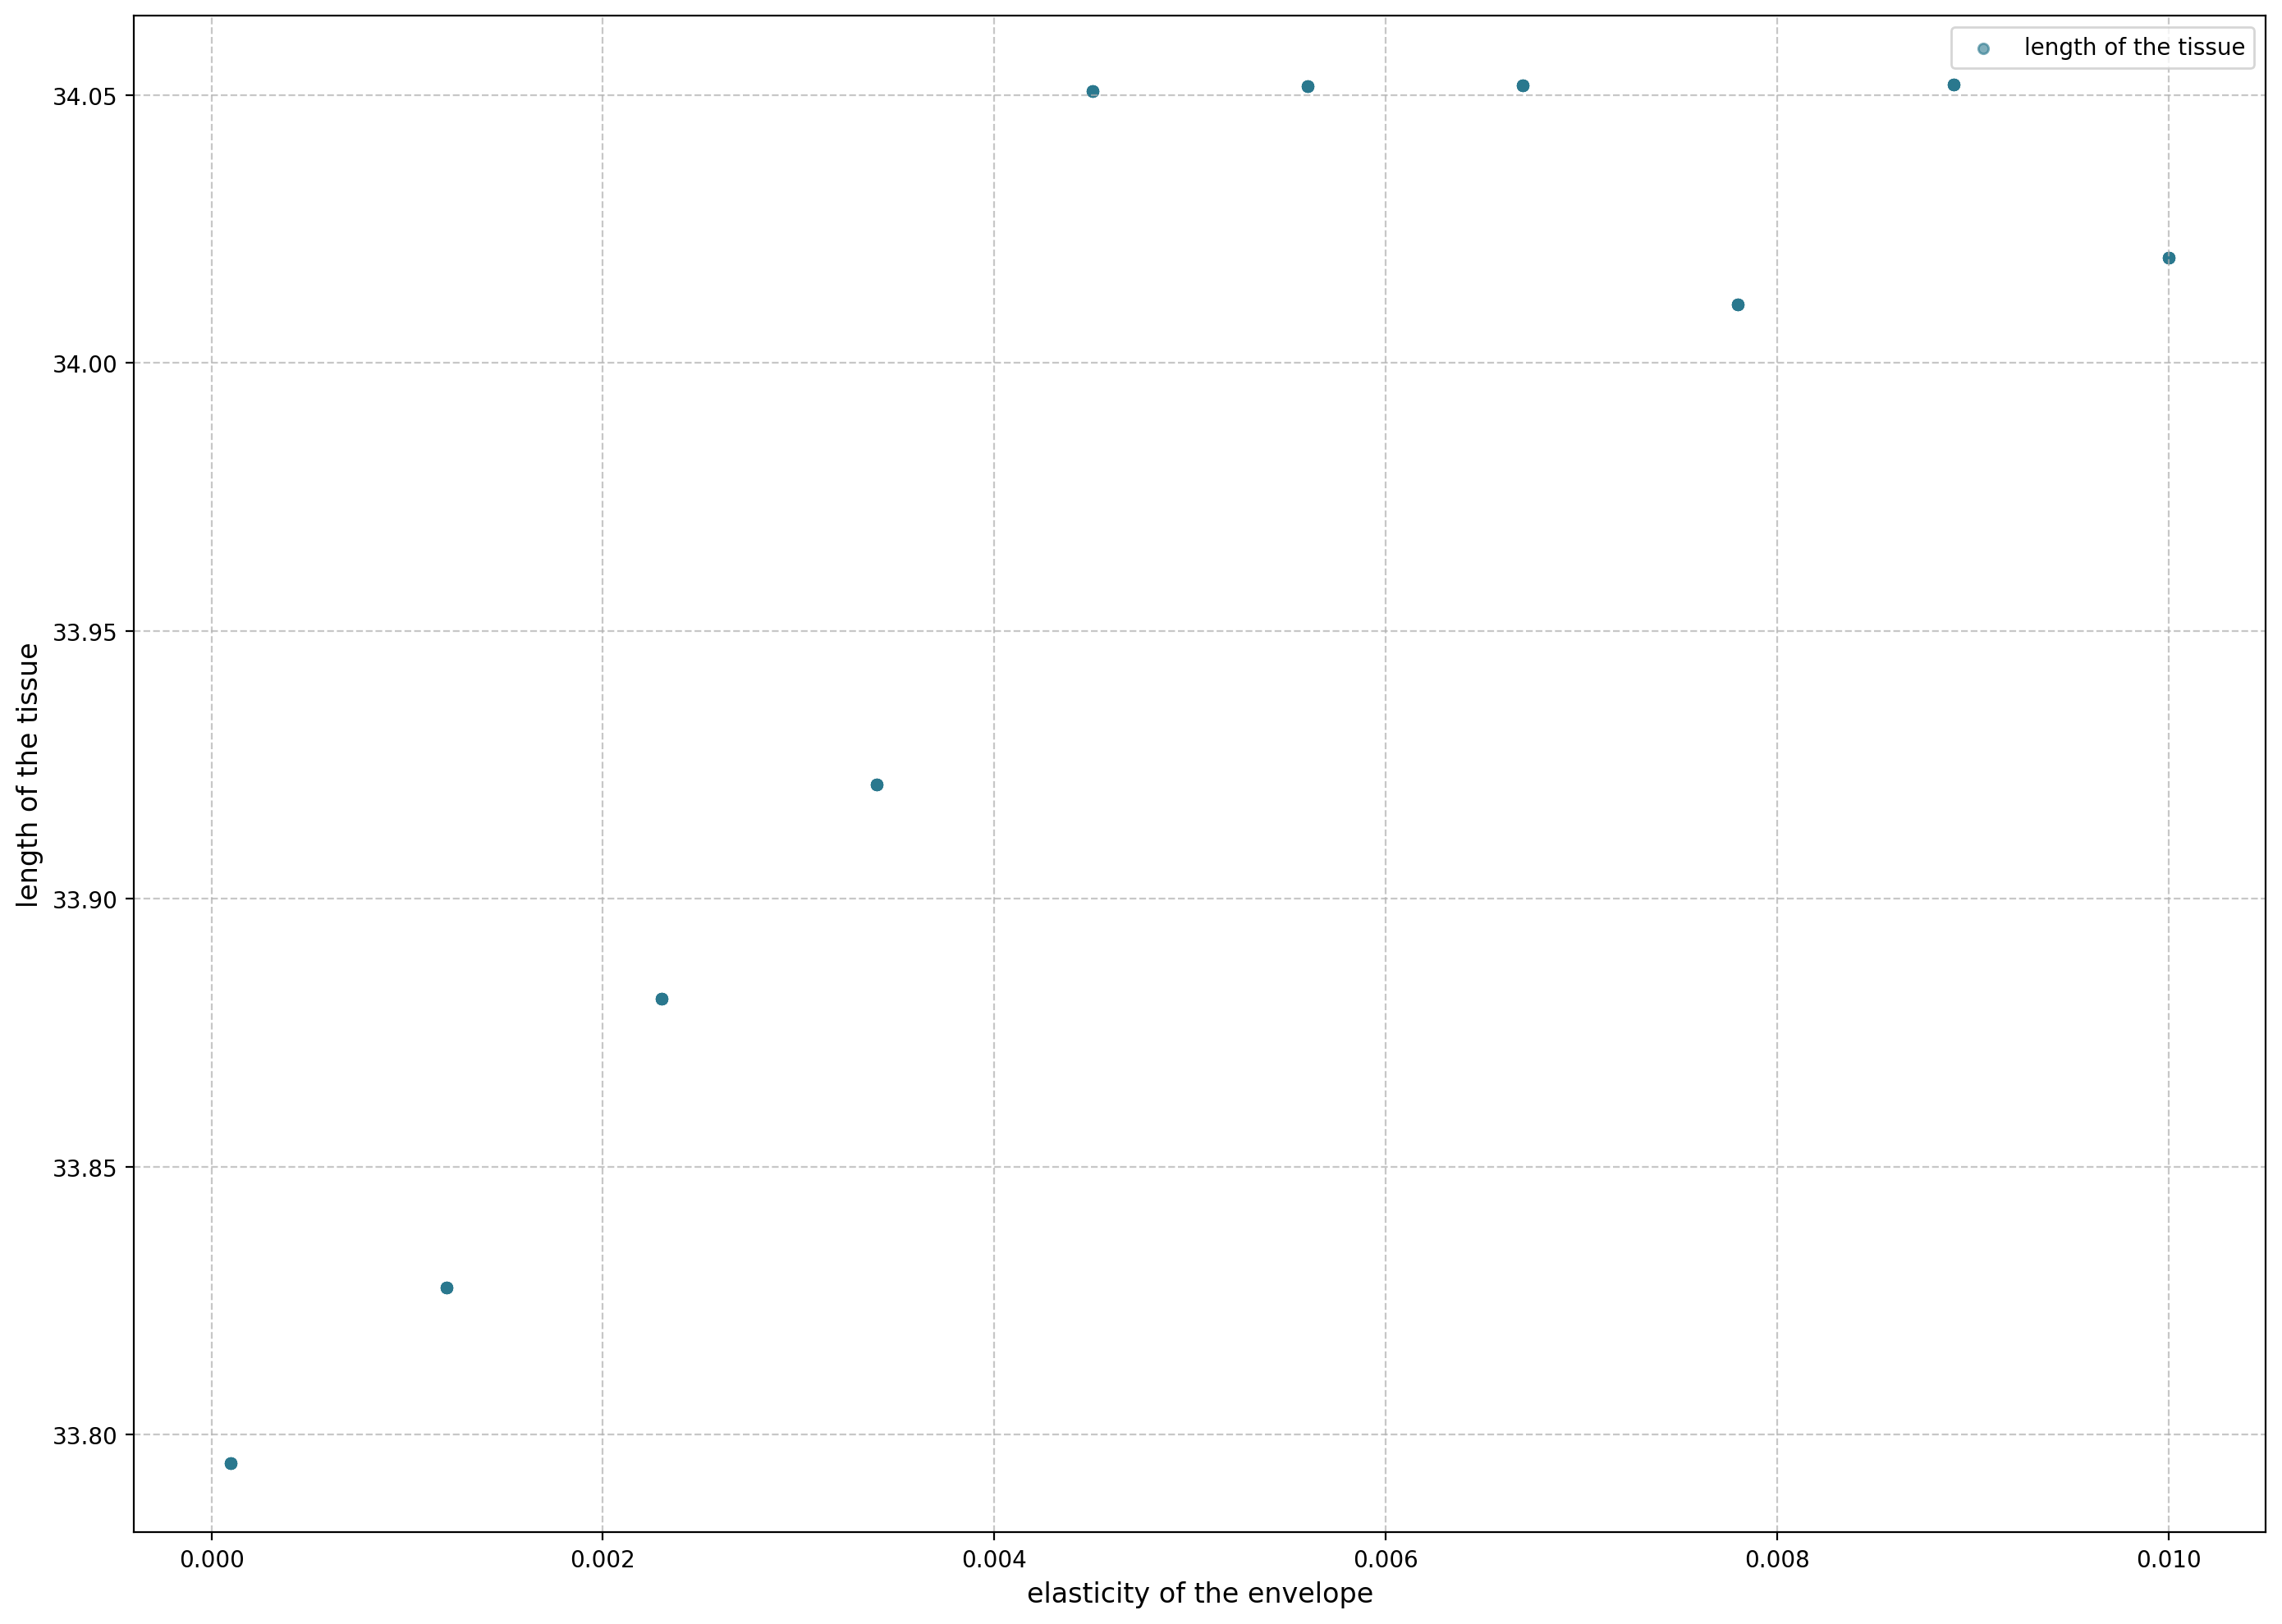

In [20]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(12, 6))  # Augmentez la taille de la figure
axs.plot(l_list, diameter_list, label='length of the tissue', color=colors[1])
axs.set_xlabel('elasticity of the envelope', fontsize=12)
axs.set_ylabel('length of the tissue', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/Simulation_be_le_diameter_lumen.png', transparent=False)
plt.show()